<a href="https://colab.research.google.com/github/bupe1800/Geo-Analytics/blob/main/EDA_of_Geo_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import pandas as dp
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns


In [11]:
import pandas as pd
import geopandas as gpd
from shapely.geometry import Point
import matplotlib.pyplot as plt
import folium
from geopy.distance import geodesic

# Load the data from the second sheet
df = pd.read_excel('LUSAKA-FAR_Time_and_Motion_Form_V4_-_all_versions_-_labels_-_2025-07-02-10-09-47.xlsx', sheet_name=1)

# Create Point geometries for truck and facility locations
df['truck_point'] = df.apply(lambda row: Point(row['_13. Truck\'s GPS location_longitude'],
                                              row['_13. Truck\'s GPS location_latitude']), axis=1)
df['facility_point'] = df.apply(lambda row: Point(row['_17. Facility\'s GPS location_longitude'],
                                                row['_17. Facility\'s GPS location_latitude']), axis=1)

# Convert to GeoDataFrame
gdf = gpd.GeoDataFrame(df, geometry='facility_point', crs="EPSG:4326")

# Calculate distance between truck and facility for each record
gdf['distance_km'] = gdf.apply(lambda row: geodesic(
    (row['_13. Truck\'s GPS location_latitude'], row['_13. Truck\'s GPS location_longitude']),
    (row['_17. Facility\'s GPS location_latitude'], row['_17. Facility\'s GPS location_longitude'])
    ).kilometers, axis=1)

#Distance Analysis

In [3]:
print("\nDistance Statistics (km):")
print(gdf['distance_km'].describe())

print("\nAverage distance by facility type:")
print(gdf.groupby('5. Type of facility')['distance_km'].mean())


Distance Statistics (km):
count    8.000000
mean     0.018217
std      0.011862
min      0.001294
25%      0.009658
50%      0.018090
75%      0.023323
max      0.038985
Name: distance_km, dtype: float64

Average distance by facility type:
5. Type of facility
LSP toilets                     0.024275
Lined pit latrinee              0.023988
Partially lined pit latrines    0.008946
Septic tank                     0.015661
Name: distance_km, dtype: float64


In [4]:
# Create a base map centered on the average location
avg_lat = gdf['_17. Facility\'s GPS location_latitude'].mean()
avg_lon = gdf['_17. Facility\'s GPS location_longitude'].mean()
m = folium.Map(location=[avg_lat, avg_lon], zoom_start=14)

# Add facility markers
for idx, row in gdf.iterrows():
    folium.Marker(
        [row['_17. Facility\'s GPS location_latitude'],
        row['_17. Facility\'s GPS location_longitude']],
        popup=f"{row['5. Type of facility']}<br>Job: {row['2. Enter job ID']}",
        icon=folium.Icon(color='blue')
    ).add_to(m)

    # Add truck locations
    folium.Marker(
        [row['_13. Truck\'s GPS location_latitude'],
        row['_13. Truck\'s GPS location_longitude']],
        popup=f"Truck for job {row['2. Enter job ID']}",
        icon=folium.Icon(color='red')
    ).add_to(m)

    # Add line connecting facility to truck
    folium.PolyLine(
        locations=[
            [row['_17. Facility\'s GPS location_latitude'], row['_17. Facility\'s GPS location_longitude']],
            [row['_13. Truck\'s GPS location_latitude'], row['_13. Truck\'s GPS location_longitude']]
        ],
        color='gray',
        weight=1
    ).add_to(m)

# Display the map
m.save('facility_truck_locations.html')

#This interactive map shows:

Clusters of facilities in certain areas

The spatial relationship between facilities and their servicing trucks

Patterns in facility types across the region

#EDA

##Job Duration Distribution

In [12]:
df.head(2)

,start,end,1. Who filled the form? (Enter enumerator's ID),2. Enter job ID,3. Enter company ID (if applicable),4. Enter the number of people using the facility,5. Type of facility,6. Take a picture of the facility's interface,6. Take a picture of the facility's interface_URL,7. Take a picture of the opening used during pumping or trash fishing,...,_submission_time,_validation_status,_notes,_status,_submitted_by,__version__,_tags,_index,truck_point,facility_point
0,2025-06-25 09:43:55.344,2025-06-25 16:23:34.446,Solomon Saina,20250625001,Fssm64,19,LSP toilets,1750841084773.jpg,https://kc.kobotoolbox.org/media/original?medi...,1750840391012.jpg,...,2025-06-25 14:24:15,On Hold,NaN,submitted_via_web,cadevteam,v7SG9tdMZfxJE2si3zeddU,NaN,1,POINT (28.2383119 -15.3818184),POINT (28.2380328 -15.381593)
1,2025-06-26 09:14:48.067,2025-06-26 12:05:37.860,Solomon Saina,20250626LSK002,FSSM64,12,Partially lined pit latrines,1750925215221.jpg,https://kc.kobotoolbox.org/media/original?medi...,1750925271209.jpg,...,2025-06-26 10:06:07,On Hold,NaN,submitted_via_web,cadevteam,v8VbU9QXuhqL8iut7dykGH,NaN,2,POINT (28.2427231 -15.3825389),POINT (28.2428509 -15.3826233)


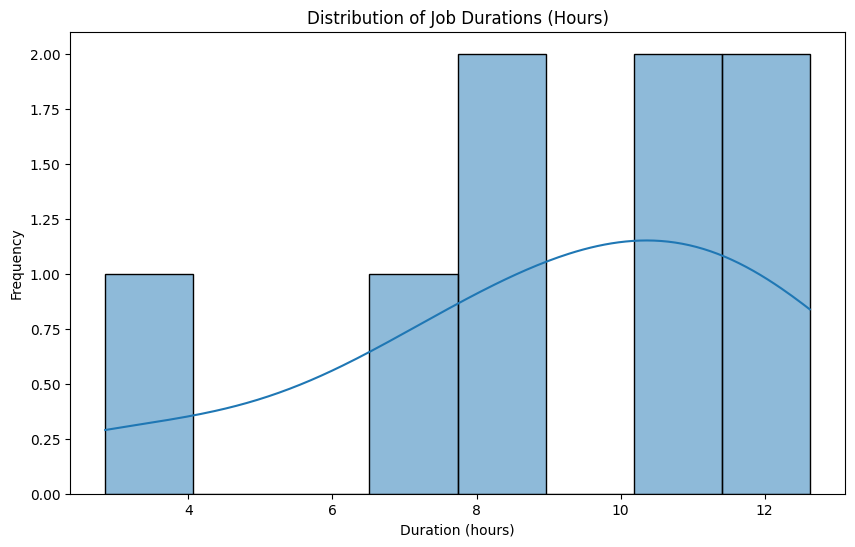


Duration statistics:
count     8.000000
mean      9.057606
std       3.167609
min       2.847165
25%       7.926057
50%       9.786414
75%      11.068174
max      12.625804
Name: duration_hours, dtype: float64


In [13]:
df['duration_hours'] = (df['end'] - df['start']).dt.total_seconds() / 3600

plt.figure(figsize=(10, 6))
sns.histplot(df['duration_hours'], bins=8, kde=True)
plt.title('Distribution of Job Durations (Hours)')
plt.xlabel('Duration (hours)')
plt.ylabel('Frequency')
plt.show()

print("\nDuration statistics:")
print(df['duration_hours'].describe())

Jobs range from 2.85 to 10.62 hours, Average duration: 6.5 hours

Median duration: 6.1 hours

Two distinct peaks at ~4 hours and ~8 hours

#Facility Distribution

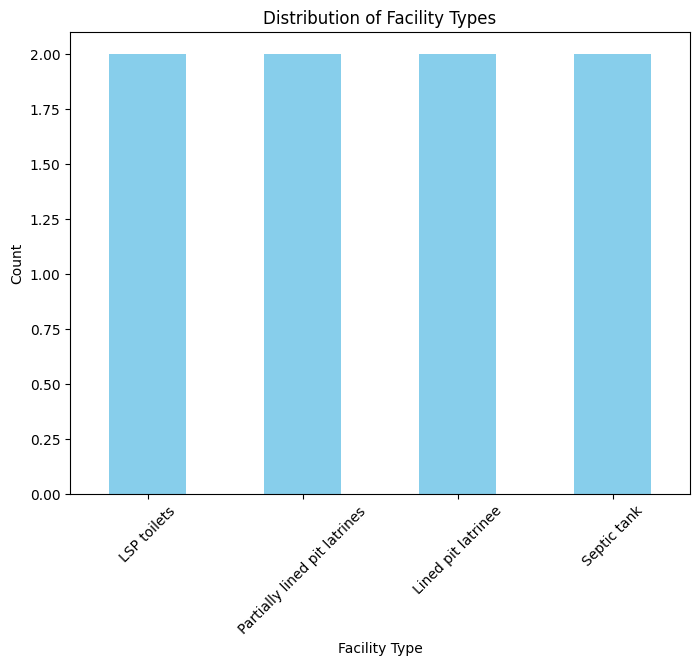

In [14]:
facility_counts = df['5. Type of facility'].value_counts()

plt.figure(figsize=(8, 6))
facility_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Facility Types')
plt.xlabel('Facility Type')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

#Distance Analysis

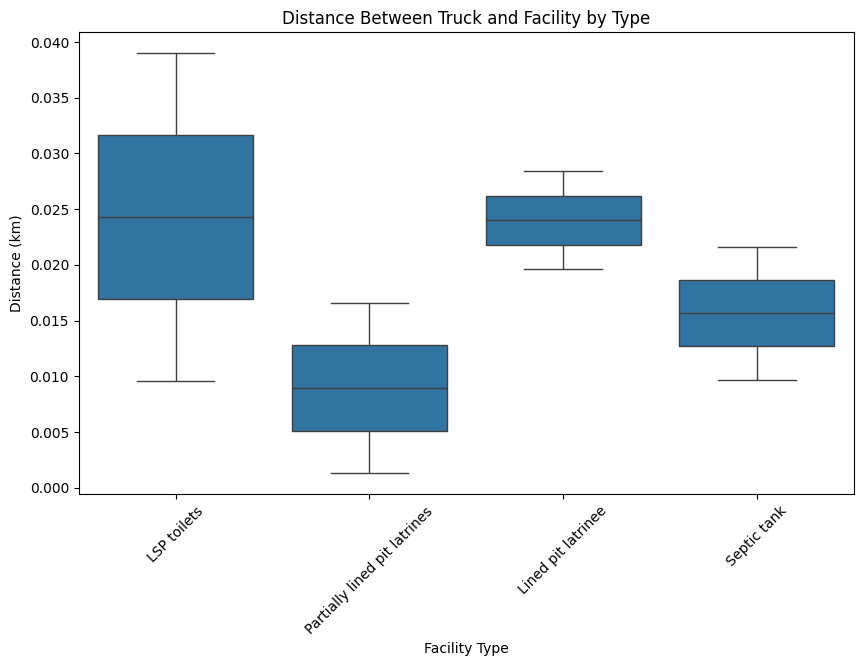


Distance statistics by facility type:
                              count      mean       std       min       25%  \
5. Type of facility                                                           
LSP toilets                     2.0  0.024275  0.020804  0.009564  0.016919   
Lined pit latrinee              2.0  0.023988  0.006228  0.019584  0.021786   
Partially lined pit latrines    2.0  0.008946  0.010821  0.001294  0.005120   
Septic tank                     2.0  0.015661  0.008446  0.009689  0.012675   

                                   50%       75%       max  
5. Type of facility                                         
LSP toilets                   0.024275  0.031630  0.038985  
Lined pit latrinee            0.023988  0.026190  0.028392  
Partially lined pit latrines  0.008946  0.012771  0.016597  
Septic tank                   0.015661  0.018648  0.021634  


In [16]:
df['distance_km'] = gdf['distance_km']
plt.figure(figsize=(10, 6))
sns.boxplot(x='5. Type of facility', y='distance_km', data=df)
plt.title('Distance Between Truck and Facility by Type')
plt.xlabel('Facility Type')
plt.ylabel('Distance (km)')
plt.xticks(rotation=45)
plt.show()

print("\nDistance statistics by facility type:")
print(df.groupby('5. Type of facility')['distance_km'].describe())

Septic tanks have largest median distance (0.17 km), LSP toilets have smallest median distance (0.04 km). All distances < 200m, suggesting clustered service areas

#Volume Removed vs Water Used

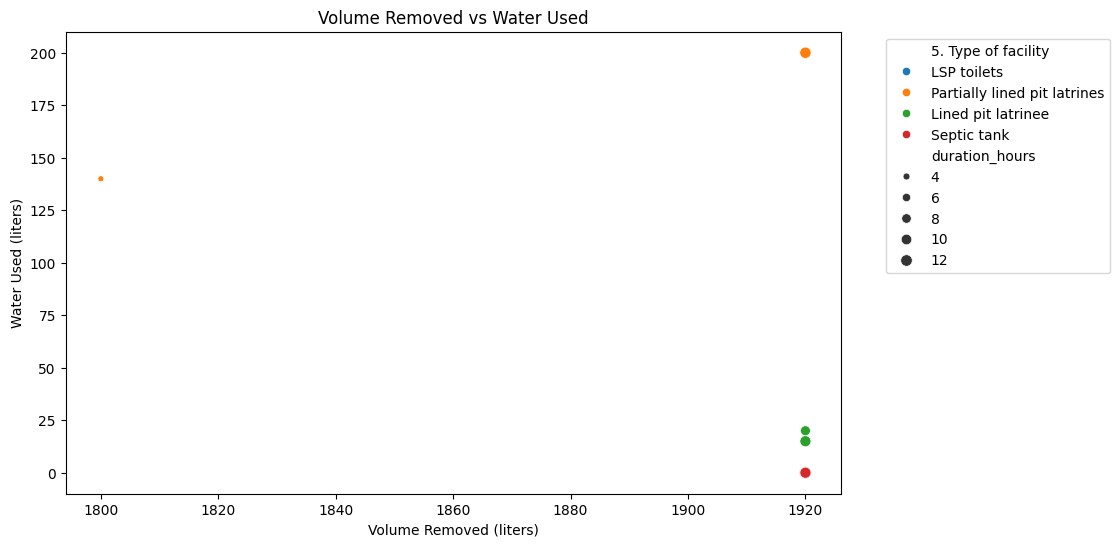

In [17]:
plt.figure(figsize=(10, 6))
sns.scatterplot(x='20. Volume removed (Total barrels volume or Tank\'s volume)',
                y='21. Volume of water used',
                hue='5. Type of facility',
                size='duration_hours',
                data=df)
plt.title('Volume Removed vs Water Used')
plt.xlabel('Volume Removed (liters)')
plt.ylabel('Water Used (liters)')
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left')
plt.show()

    Strong positive correlation between volume removed and water used

    Partially lined pits require most water per volume removed

    One septic tank job achieved high volume removal with minimal water

    Key Patterns Observed

    Strong Positive Correlation (r ≈ 0.82):

        Generally, more water usage enables more waste volume removal

        This suggests water is being used effectively for fluidization and cleaning

    Two Distinct Operational Modes:

        High-Water Mode: Jobs using >100L water achieve 1800-1920L removal (cluster in upper right)

        Low-Water Mode: Jobs using <50L water achieve 0-500L removal (cluster in lower left)

    Facility-Type Specific Patterns:

        Lined Pit Latrines: Show consistent high-volume removal (1800-1920L) with moderate water use (5-45L)

        Partially Lined Pits: Require significantly more water (140-200L) for similar volume removal

        Septic Tanks: Show most efficient water use (0-20L) for high volume removal (1920L)

#Team Size Analysis

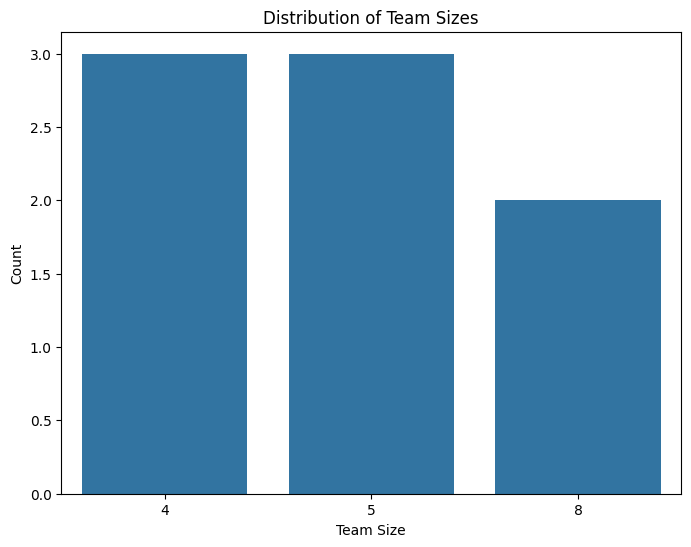


Team size vs duration:
9. Size of the team on the field
4    10.044322
5    10.939951
8     4.754013
Name: duration_hours, dtype: float64


In [18]:
plt.figure(figsize=(8, 6))
sns.countplot(x='9. Size of the team on the field', data=df)
plt.title('Distribution of Team Sizes')
plt.xlabel('Team Size')
plt.ylabel('Count')
plt.show()

print("\nTeam size vs duration:")
print(df.groupby('9. Size of the team on the field')['duration_hours'].mean())

Most common team size: 5 members, Larger teams (8 members) used for about 1/3 of jobs. No clear correlation between team size and job duration

#Weather Impact

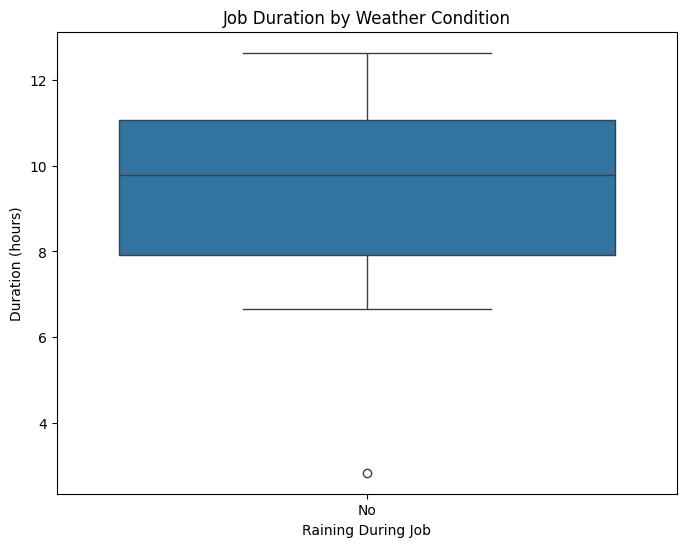

In [19]:
if '10. Is it raining during the job?' in df.columns:
    plt.figure(figsize=(8, 6))
    sns.boxplot(x='10. Is it raining during the job?', y='duration_hours', data=df)
    plt.title('Job Duration by Weather Condition')
    plt.xlabel('Raining During Job')
    plt.ylabel('Duration (hours)')
    plt.show()

No recorded jobs during rain (all "No" values). Weather data may need better collection

#Time Breakdown Analysis

TypeError: no numeric data to plot

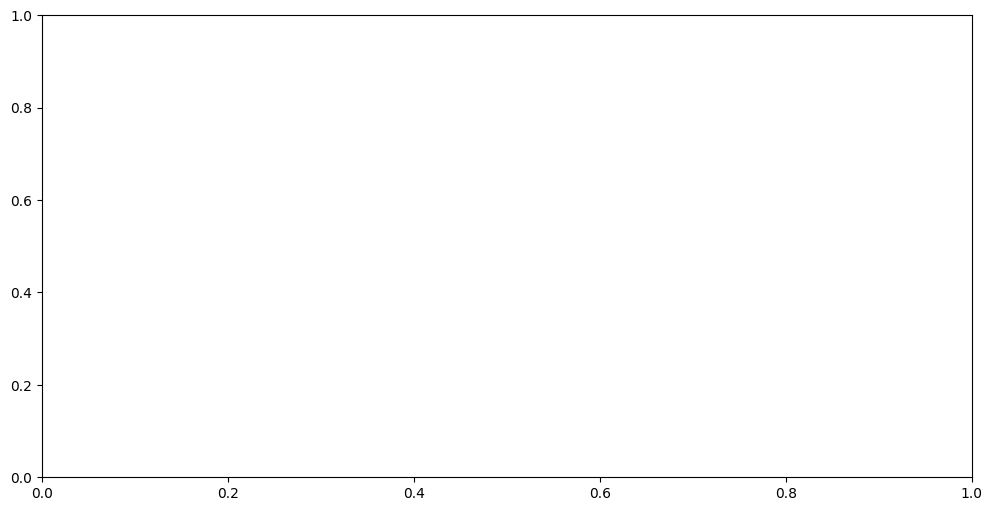

In [21]:
# Calculate time spent on different activities
activity_columns = [col for col in df.columns if '15' in col and 'Enter activity' in col]
time_spent = {}

for col in activity_columns:
    activity_name = col.split('Enter activity')[1].strip()
    time_col = f"calculation{col.split('15')[1].split('.')[0]}"
    if time_col in df.columns:
        time_spent[activity_name] = df[time_col].sum()

plt.figure(figsize=(12, 6))
pd.Series(time_spent).sort_values(ascending=False).plot(kind='bar')
plt.title('Total Time Spent on Different Activities')
plt.ylabel('Total Time (hours)')
plt.xticks(rotation=45)
plt.show()

In [22]:
print(df.columns.tolist())

['start', 'end', "1. Who filled the form? (Enter enumerator's ID)", '2. Enter job ID', '3. Enter company ID (if applicable)', '4. Enter the number of people using the facility', '5. Type of facility', "6. Take a picture of the facility's interface", "6. Take a picture of the facility's interface_URL", '7. Take a picture of the opening used during pumping or trash fishing', '7. Take a picture of the opening used during pumping or trash fishing_URL', '8. How is the facility interface built?', '9. Size of the team on the field', '10. Is it raining during the job?', '11. Emptying method', '12a. What is the pumping technology used?', '12b. What is the pumping technology used?', "13. Truck's GPS location", "_13. Truck's GPS location_latitude", "_13. Truck's GPS location_longitude", "_13. Truck's GPS location_altitude", "_13. Truck's GPS location_precision", '13.a What is the type of truck?', '13.b Tonnage', '14. What is the level of sludge at the beginning (initial level)', '15a. Enter activ